In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Process

* Set imports
* Define model architecture
* set device(GPU or CPU)
* Define hyperparameters
* Create your(custom) Dataset(inherits from the Dataset class)
    * Define DataSets
    * Define DataLoaders
* initialize/instantiate network
* Compile model
    * Define loss
    * Define optimizer
* Train the network (create training for loop)
    set model to training mode? model.train()?
    * for epochs
        * for batch, features, labels in DataLoader
            * set data to the device(import for cuda, ie. gpu enabled)
            * Forward pass: predictions and loss
            * Backward pass: optimizer.zero_grad() & loss.backward()
            * Gradient descent: optimizer.step()
* Define testing/validation loop
    * remember: set model to evaluation mode(with torch.zero_grad??? or model.eval()???)
    

* Data Augmentation (extra step for image data)
    * Done with PyTorch Transforms
    * `import torchvision.transforms as transforms`
    * `my_transforms = transforms.Compose([your list of transformations go here])`
    * tranforms get implemented in datasets when you include them in the `transforms` argument of the dataset

In [2]:
# imports
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from tqdm import tqdm  
import torchvision.transforms as transforms

import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Hyperparameters
learning_rate = 0.001 #3e-4 #0.001
batch_size = 80 #48 #16 #32 #64 #80

In [4]:
df = pd.read_csv("../input/siim-isic-melanoma-classification/train.csv")

In [5]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [6]:
# df = df[["image_name","target"]].sample(3000, random_state=125)

In [7]:
# df[["image_name","target"]][df["target"] == 1].info()

In [8]:
# Dataset
class Melanoma_Dataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.annotations = dataframe
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        length = self.annotations.shape[0]
        return length
    
    def __getitem__(self, idx):
        image_name = self.annotations["image_name"].iloc[idx]
        target = self.annotations["target"].iloc[idx]
        image_path = self.root_dir + "/" + image_name + ".jpg"
        image = img.imread(image_path)
        
        if self.transform is not None:
            image = self.transform(image)
        
        target = torch.tensor([target], dtype=torch.float32)
            
        return image, target

In [9]:
#VGG16 model

# base_model_resnext50 = torchvision.models.resnext50_32x4d(pretrained=True)
# torch.save(base_model_resnext50, "./resnext50_32x4d.pt") # saves to "output"

base_model_resnext50 = torch.load("../input/siimmelanomatrainedmodels/resnext50_32x4d.pt")


# base_model_resnext101 = torchvision.models.resnext101_32x8d(pretrained=True)
# torch.save(base_model_resnext101, "./resnext101_32x8d.pt") # saves to "output"

# base_model_resnext101 = torch.load("./resnext101_32x8d.pt")


# print(base_model)

In [10]:
# print(base_model)

In [11]:
# print(base_model)

class ResNext50_base(nn.Module):
    def __init__(self, base_trainable=False):
        super(ResNext50_base, self).__init__()
        
        self.resnext50_base = base_model_resnext50
        
        for param in self.resnext50_base.parameters():
            param.requires_grad = base_trainable
        
        self.fc1 = nn.Linear(1000, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 750)
        self.fc4 = nn.Linear(750, 500)
        self.fc5 = nn.Linear(500, 100)
        self.fc6 = nn.Linear(100, 1)
        
    def forward(self, x):
        x = self.resnext50_base(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x



# class ResNext101_base(nn.Module):
#     def __init__(self, base_trainable=False):
#         super(ResNext101_base, self).__init__()
        
#         self.resnext101_base = base_model_resnext101
        
#         for param in self.resnext101_base.parameters():
#             param.requires_grad = base_trainable
        
#         self.fc1 = nn.Linear(1000, 1000)
#         self.fc2 = nn.Linear(1000, 1000)
#         self.fc3 = nn.Linear(1000, 750)
#         self.fc4 = nn.Linear(750, 500)
#         self.fc5 = nn.Linear(500, 100)
#         self.fc6 = nn.Linear(100, 1)
        
#     def forward(self, x):
#         x = self.resnext101_base(x)
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.relu(self.fc3(x))
#         x = torch.relu(self.fc4(x))
#         x = torch.relu(self.fc5(x))
#         x = self.fc6(x)
#         return x

In [12]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# augmentations/transforms
images_mean = (0.8060590931711208, 0.620982283291032, 0.5915027590675953)
images_std = (0.08131081913267031, 0.09455098010432171, 0.10589780296354254)
image_transforms = transforms.Compose(
    [  # Compose makes it possible to have many transforms
        transforms.ToPILImage(),
        transforms.RandomRotation(degrees=90),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(), # Note: ToTensor() actually scales pixel values between 0 and 1
        transforms.Normalize(mean=images_mean, std=images_std),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=images_mean, std=images_std),
    ]
)

In [14]:
train_df, test_df = train_test_split(df, test_size=0.1) #, random_state=125)

In [15]:
total_samples = len(train_df["target"])
class_1_count = sum(train_df["target"]) + 0.0001 #in case class_1_count is zero
class_0_count = total_samples - class_1_count
class_weights = [total_samples/class_0_count, total_samples/class_1_count]

list_of_weights = [class_weights[i] for i in train_df["target"]]
weighted_sampler = WeightedRandomSampler(list_of_weights, num_samples = len(list_of_weights), replacement=True)

In [16]:
# # Instantiate Datasets and DataLoaders
# # root_directory = "../input/siim-isic-melanoma-classification/jpeg/train"
root_directory = "../input/siimisic-resized-224x224-jpeg/output_train/train"

train_ds = Melanoma_Dataset(train_df, root_dir=root_directory, transform=image_transforms)
test_ds = Melanoma_Dataset(test_df, root_dir=root_directory, transform=image_transforms)

train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, sampler=weighted_sampler,
                          num_workers=1, pin_memory=True)#, shuffle=True) #set shuffle=True
test_loader = DataLoader(dataset=test_ds, batch_size=batch_size, 
                         num_workers=1, pin_memory=True, shuffle=True)

In [17]:
# # find mean and std deviation of images for transforms.Normalize()
# def compute_mean_and_std(dataloader):
#     count = 0
#     mean_1 = 0
#     mean_2 = 0
#     mean_3 = 0
#     std_1 = 0
#     std_2 = 0
#     std_3 = 0
#     for batch, (X, y) in enumerate(dataloader):

#         X = X.to(device=device)

#         for image in X:
#             mean_1 += torch.mean(image[0]).item() # .item() converts 'tensor(0.005)' to '0.005'
#             mean_2 += torch.mean(image[1]).item()
#             mean_3 += torch.mean(image[2]).item()
#             std_1 += torch.std(image[0]).item()
#             std_2 += torch.std(image[1]).item()
#             std_3 += torch.std(image[2]).item()

#             count += 1
#             print(count, end="\r")
    
#     mean_final = (mean_1/count, mean_2/count, mean_3/count)
#     std_final = (std_1/count, std_2/count, std_3/count)
    
#     return mean_final, std_final

In [18]:
# mean_, std_ = compute_mean_and_std(train_loader)

# print(mean_, std_)

In [19]:
# Instantiate network

model = ResNext50_base(base_trainable=True).to(device)
# model = ResNext101_base(base_trainable=True).to(device)
# model = torch.load("./ResNext101_trained_5_epochs.pt")


# model_checkpoint = torch.load("../input/siimmelanomatrainedmodels/resnext50_model_checkpoint_epoch_39.pt", 
#                               map_location=device)
# model = ResNext50_base(base_trainable=True).to(device)
# model_state_dict = model_checkpoint["model_state"]
# model.load_state_dict(model_state_dict)
# model = model.to(device)

# using a model state_dict
# model_state_dict = torch.load("path-to-state_dict", 
#                               map_location=device)
# model.load_state_dict(model_state_dict)
# model = model.to(device)

In [20]:
# model_checkpoint["scheduler_state"]

In [21]:
# Focal Loss Function
# from this blog post: https://amaarora.github.io/2020/06/29/FocalLoss.html

class WeightedFocalLoss(nn.Module):
    "Non weighted version of Focal Loss"
    def __init__(self, alpha=.25, gamma=2):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = torch.tensor([alpha, 1-alpha]).to(device)  #.cuda() #remember to define "device"
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        targets = targets.type(torch.long)
        at = self.alpha.gather(0, targets.data.view(-1))
        pt = torch.exp(-BCE_loss)
        F_loss = at*(1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

In [22]:
# Loss and optimizer
# loss_function = nn.BCEWithLogitsLoss()
loss_function = WeightedFocalLoss(alpha=0.25, gamma=2.0)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# learning rate scheduler
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=learning_rate, 
#                                               max_lr=0.1,step_size_up=5,mode="triangular2")



# from abishek thakur: https://www.kaggle.com/abhishek/melanoma-detection-with-pytorch?scriptVersionId=35193166
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       patience=3, 
                                                       threshold=0.001, 
                                                       mode="min"
                                                      )

# es = EarlyStopping(patience=5, mode="max")


In [23]:
import math

# # from documentation: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    print(f"Total samples: {size}")
    print(f"Batch size: {batch_size}")
    
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        
        X = X.to(device=device)
        y = y.to(device=device)
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         scheduler.step(loss)
        print(f"Batch number: {batch+1}/{math.ceil(size/batch_size)}", end="\r")
    
    print("\n")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    
    model.eval()
    
    predictions = []
    targets = []
    with torch.no_grad():
        for X, y in dataloader:
            
            X = X.to(device=device)
            y = y.to(device=device)
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            
            predictions.append(pred.cpu())
            targets.append(y.cpu())
    
    predictions = np.vstack(predictions).ravel()
    targets = np.vstack(targets).ravel() #test_df["target"].values
    auc = sklearn.metrics.roc_auc_score(targets, predictions)

    test_loss /= size
#     auc /= size
    # print(f"Avg loss: {test_loss:>8f} \n")
    print(f"Avg loss: {test_loss}, AUC = {auc} \n")
    
    return test_loss, auc

In [24]:
# Training Loop with AMP(automatic mixed precision)

# mixed precision scaler
scaler = torch.cuda.amp.GradScaler()

def train_loop_amp(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    print(f"Total samples: {size}")
    print(f"Batch size: {batch_size}")
    
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        
        X = X.to(device=device)
        y = y.to(device=device)
        
        
        # forward
        with torch.cuda.amp.autocast():
            pred = model(X)
            loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        print(f"Batch number: {batch+1}/{math.ceil(size/batch_size)}", end="\r")
    
    print("\n")

In [25]:
print(device)

cuda


In [26]:
# def train_model(model, train_loader, test_loader, loss_function, optimizer, epochs=5):
#     # lowest_loss = np.inf #float("inf")
#     top_3_models = []
#     for t in range(epochs):
#         print(f"Epoch {t+1}\n-------------------------------")
# #         if device == "cuda":
# #             train_loop_amp(train_loader, model, loss_function, optimizer)
# #         else:
# #             train_loop(train_loader, model, loss_function, optimizer)


#         train_loop(train_loader, model, loss_function, optimizer)
#         test_loss = test_loop(test_loader, model, loss_function)
        
#         # saving model checkpoint
#         checkpoint = {"epoch": t+1, 
#                       "model_state": model.state_dict(), 
#                       "optimizer_state": optimizer.state_dict(),
#                       "scheduler_state": scheduler.state_dict(), 
#                       "loss": test_loss}
        
#         if len(top_3_models) == 0:
#             torch.save(checkpoint, f"./resnext50_model_checkpoint_epoch_{t+1}.pt")
#             top_3_models.append({"filename": f"./resnext50_model_checkpoint_epoch_{t+1}.pt", 
#                                  "loss": test_loss})
        
#         if test_loss < top_3_models[0]["loss"]:
#             torch.save(checkpoint, f"./resnext50_model_checkpoint_epoch_{t+1}.pt")
#             top_3_models.append({"filename": f"./resnext50_model_checkpoint_epoch_{t+1}.pt", 
#                                  "loss": test_loss})

#         if len(top_3_models) > 3:
#             file_to_remove = top_3_models[0]["filename"]
#             os.remove(file_to_remove)
#             top_3_models.pop(0)

#         # sort in descending order by loss 
#         top_3_models = sorted(top_3_models, key=lambda k: k["loss"], reverse=True)
            
#         # print(f"top_3_models length: {len(top_3_models)}")
            
#     print("Done!")
    
#     return model


def train_model(model, train_loader, test_loader, loss_function, optimizer, epochs=5, epochs_pretrained=0):
    # lowest_loss = np.inf #float("inf")
    top_3_models = []
    for t in range(epochs):
        print(f"Epoch {t+1}[{epochs_pretrained+t+1} in total]\n-------------------------------")
#         if device == "cuda":
#             train_loop_amp(train_loader, model, loss_function, optimizer)
#         else:
#             train_loop(train_loader, model, loss_function, optimizer)


        train_loop(train_loader, model, loss_function, optimizer)
        test_loss, test_auc = test_loop(test_loader, model, loss_function)
        
        scheduler.step(test_loss)
        # saving model checkpoint
        checkpoint = {"epoch": epochs_pretrained+t+1, 
                      "model_state": model.state_dict(), 
                      "optimizer_state": optimizer.state_dict(),
                      "scheduler_state": scheduler.state_dict(), 
                      "loss": test_loss, 
                      "auc": test_auc}
        
        save_location = f"./resnext50_model_checkpoint_epoch_{epochs_pretrained+t+1}.pt"
#         save_location = f"./resnext101_model_checkpoint_epoch_{epochs_pretrained+t+1}.pt"
        
        # always save on first epoch
        if len(top_3_models) == 0:
            torch.save(checkpoint, save_location)
            top_3_models.append({"filename": save_location, 
                                 "loss": test_loss})
        
        # save if loss is lower than highest/worst loss of saved models
        if test_loss < top_3_models[0]["loss"]:
            torch.save(checkpoint, save_location)
            top_3_models.append({"filename": save_location, 
                                 "loss": test_loss})
        
        # removes worst performing model, but only if there are 3 or more models already saved
        # keeps the 3 best models(measured by loss on validation set)
        if len(top_3_models) > 3:
            file_to_remove = top_3_models[0]["filename"]
            os.remove(file_to_remove)
            top_3_models.pop(0)

        # sort in descending order by loss 
        top_3_models = sorted(top_3_models, key=lambda k: k["loss"], reverse=True)
            
        # print(f"top_3_models length: {len(top_3_models)}")
        
        # always save last epoch
        if t == epochs-1:
            torch.save(checkpoint, save_location)
            top_3_models.append({"filename": save_location, 
                                 "loss": test_loss})
            
    print("Done!")
    
    return model

In [27]:
model = train_model(model, train_loader, test_loader, loss_function, optimizer, 
                    epochs=10, epochs_pretrained=0) #model_checkpoint["epoch"])

Epoch 1[1 in total]
-------------------------------
Total samples: 29813
Batch size: 80
Batch number: 373/373

Avg loss: 0.00019476667058915845, AUC = 0.8899771192588872 

Epoch 2[2 in total]
-------------------------------
Total samples: 29813
Batch size: 80
Batch number: 373/373

Avg loss: 0.00016141310453678036, AUC = 0.8798761091578772 

Epoch 3[3 in total]
-------------------------------
Total samples: 29813
Batch size: 80
Batch number: 373/373

Avg loss: 0.0001659120351756135, AUC = 0.8966850828729281 

Epoch 4[4 in total]
-------------------------------
Total samples: 29813
Batch size: 80
Batch number: 373/373

Avg loss: 0.00016428288024558676, AUC = 0.8601484457838049 

Epoch 5[5 in total]
-------------------------------
Total samples: 29813
Batch size: 80
Batch number: 373/373

Avg loss: 0.00012416946477518992, AUC = 0.8877615938389418 

Epoch 6[6 in total]
-------------------------------
Total samples: 29813
Batch size: 80
Batch number: 373/373

Avg loss: 0.000143403885833364

In [28]:
# def get_predictions(dataloader, model):
#     predictions = []
#     model.eval()

#     with torch.no_grad():
#         for X, y in dataloader:
#             X = X.to(device=device)
#             pred = model(X)
#             for value in pred:
#                 predictions.append(value.cpu().numpy()[0])
            
#     return predictions

In [29]:
def get_predictions(dataloader, model):
    predictions = []
    targets = []
    model.eval()

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device=device)
            pred = model(X)
            predictions.append(pred.cpu())
            targets.append(y.cpu())
    
    predictions = np.vstack(predictions).ravel()
    targets = np.vstack(targets).ravel()
            
    return predictions, targets


def predict_multiple_epochs(dataloader, model, epochs=1):
    # Note: must use dataloader with batch_size=1
    predictions = []
    targets = []
    model.eval()
    
    for i in range(epochs):
        print(f"Epoch: {i+1}")
        pred, targ = get_predictions(dataloader, model)
        predictions.append(pred)
        if i == 0:
            targets.append(targ)
            
    targets = np.array(targets).ravel()
    predictions = np.mean(predictions, axis=0)

    return predictions, targets

In [30]:
# Reset test loader with batch_size=1
# so that we can use our predict_multiple_epochs function
# to perform test-time augmentation
test_loader_new = DataLoader(dataset=test_ds, batch_size=1, 
                             num_workers=1, pin_memory=True, shuffle=False)

In [38]:
predictions, targets = predict_multiple_epochs(test_loader_new, model, epochs=20)

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20


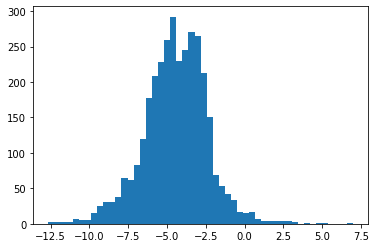

In [39]:
# plt.subplot(1, 2, 1)
plt.hist(predictions, bins=50) #, range=(0, 0.001))
plt.show()

# plt.subplot(1, 2, 2)
# plt.hist(predictions_new, bins=20)
# plt.show()

In [40]:
filtered_predictions = []
for pred in predictions:
    if pred < 0:
        filtered_predictions.append(0)
    else:
        filtered_predictions.append(1)

In [41]:
test_labels = test_df["target"].values

In [42]:
print(classification_report(test_labels, filtered_predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3258
           1       0.20      0.22      0.21        55

    accuracy                           0.97      3313
   macro avg       0.60      0.60      0.60      3313
weighted avg       0.97      0.97      0.97      3313



In [43]:
print(sklearn.metrics.roc_auc_score(targets, predictions))

0.8622579385010324


Text(0.5, 1.0, 'Confusion Matrix')

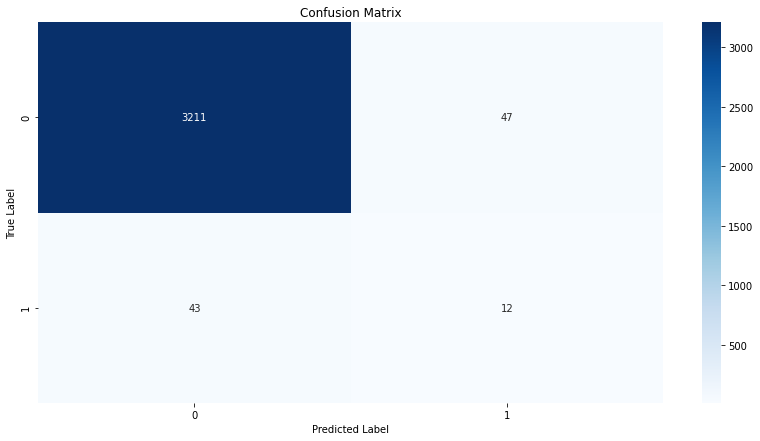

In [44]:
conf_matrix = confusion_matrix(test_labels, filtered_predictions)

plt.figure(figsize=(14,7))
sns.heatmap(conf_matrix, annot=True, cbar=True, cmap='Blues', fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")